In [1]:
#Librerias
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
#Cargar Dataset
datos, metadatos = tfds.load('fashion_mnist', as_supervised= True, with_info = True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete090DYJ/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete090DYJ/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
#Ver la metadata
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir=PosixGPath('/tmp/tmpllmkq5w4tfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao an

In [4]:
#Separar datos en train y test
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
#Visualizar datos
nombres_clases = metadatos.features['label'].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
datos_entrenamiento

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
datos_pruebas

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
#Normalizar los datos
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes,tf.float32)
  imagenes/=255  #Pasar de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y prueba
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento más rpaido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

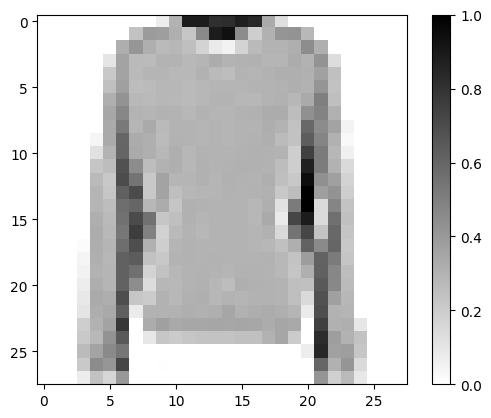

In [9]:
#Mostrar una imagen de los datos de prueba
for imagen, etiqueta in datos_entrenamiento.take(1):
  break

imagen = imagen.numpy().reshape((28,28)) #Redimensionar

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

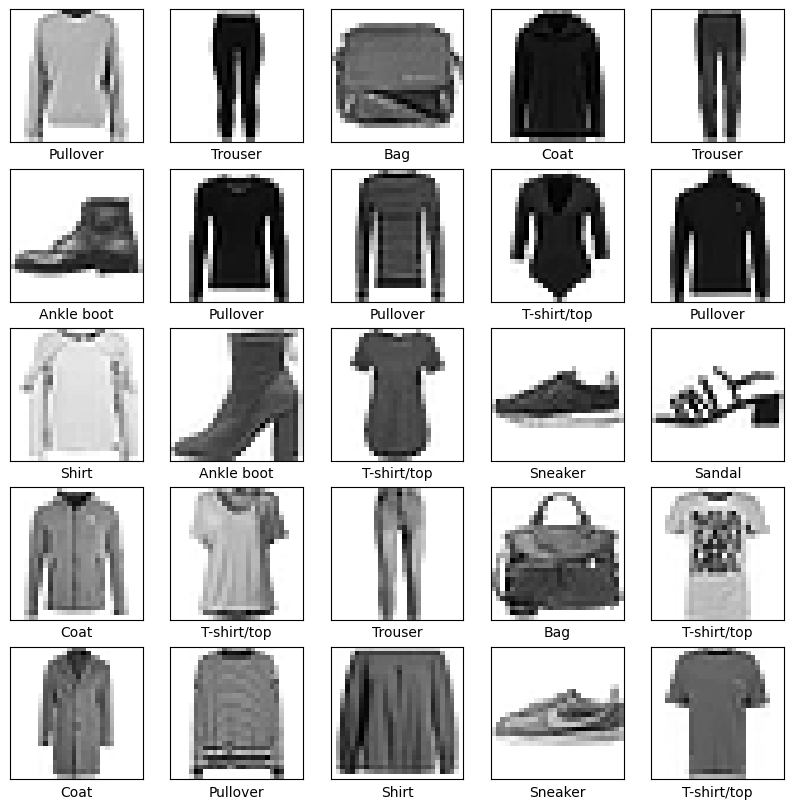

In [10]:
#Ver ejemplos de prueba ya clasificados
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap= plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [11]:
#Modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),  #1 - Blanco y negro
    tf.keras.layers.Dense(50, activation =tf.nn.relu),
    tf.keras.layers.Dense(50, activation =tf.nn.relu),
    tf.keras.layers.Dense(10, activation =tf.nn.softmax) #Para redes de clasificación
])

In [12]:
#Compilar el modelo
modelo.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [13]:
num_eje_entrenamiento = metadatos.splits['train'].num_examples
num_eje_pruebas = metadatos.splits['test'].num_examples

print(num_eje_entrenamiento)
print(num_eje_pruebas)

60000
10000


In [14]:
LOTE = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_eje_entrenamiento).batch(LOTE)
datos_pruebas  = datos_pruebas.batch(LOTE)

In [15]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs = 5, steps_per_epoch = math.ceil(num_eje_entrenamiento/LOTE))

Epoch 1/5
1875/1875 [==============================] - 16s 4ms/step - loss: 0.5162 - accuracy: 0.8191
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3788 - accuracy: 0.8628
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3399 - accuracy: 0.8749
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3265 - accuracy: 0.8803
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3048 - accuracy: 0.8879


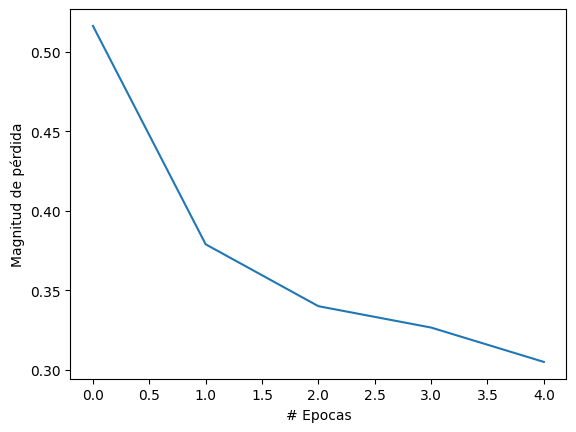

In [16]:
#Graficar la función de perdida
plt.xlabel('# Epocas')
plt.ylabel('Magnitud de pérdida')
plt.plot(historial.history['loss'])

1/1 [==============================] - 0s 129ms/step


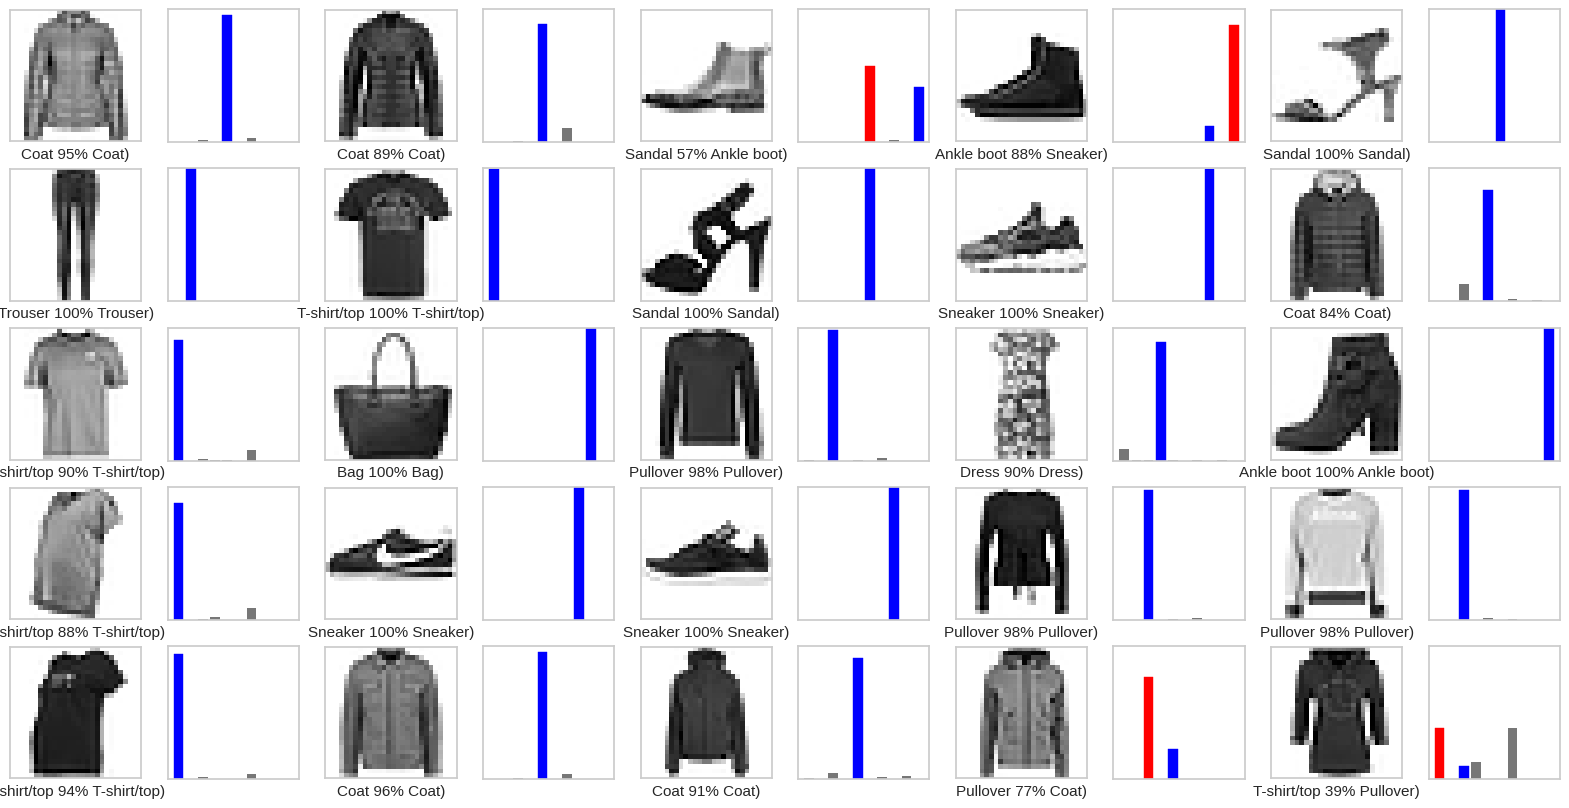

In [21]:
#Validación grafica del modelo
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap = plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue' #Si le atino
  else:
    color = 'red' #No le atino

  plt.xlabel("{} {:2.0f}% {})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real],
      color = color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color = "#777777")
  plt.ylim([0,1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')


filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))

for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [22]:
#Tomar cualquier dato para probar
imagen = imagenes_prueba[10] #Imagen index 10
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 63ms/step
Prediccion: T-shirt/top


In [ ]:
#Exportar modelo
modelo.save('RedesNeuronalesClasificarImagen.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
